# Combined re-execution results

This dataset combines results from R 3.2, 3.6 and 4.0

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import pandas as pd

# plot style
sns.set_style('whitegrid')
sns.set_style({'font.family': 'Times New Roman'})

In [2]:
%matplotlib inline

## Load success rate data

In [3]:
df_32_env = pd.read_csv("data/one-hour-run-data/run_log_r32_env.csv", sep="\t", names=["doi", "file", "r32"])
df_36_env = pd.read_csv("data/one-hour-run-data/run_log_r36_env.csv", sep="\t", names=["doi", "file", "r36"])
df_40_env = pd.read_csv("data/one-hour-run-data/run_log_r40_env.csv", sep="\t", names=["doi", "file", "r40"])

In [4]:
len(df_32_env)

5028

In [5]:
print(len(df_36_env))

6226


In [6]:
print(len(df_40_env))

5288


## Merge results in one df

In [7]:
df = pd.merge(df_32_env,df_36_env,on=['doi','file'], how='outer')

In [8]:
len(df)

7129

In [9]:
df = pd.merge(df,df_40_env,on=['doi','file'], how='outer')

In [10]:
len(df)

7621

## Combine results

In [24]:
import numpy as np

def get_combined_result(r):
    if 'success' in [r.r32, r.r36, r.r40]:
        return 'success'
    if pd.isnull(r.r36) or pd.isnull(r.r32) or pd.isnull(r.r40):
        return np.nan
    if "time limit exceeded" in [r.r32, r.r36, r.r40]:
        return np.nan
    if "not authorized" in [r.r32, r.r36, r.r40]:
        return 'auth'
    if r.r36:
        return r.r36
    if r.r40:
        return r.r40
    if r.r32:
        return r.r32

df['result'] = df.apply(get_combined_result, axis=1)

In [25]:
def get_success(el):
    if pd.isna(el):
        return el
    if el == 'success':
        return 1
    if el == 'auth':
        return -1
    if len(str(el))>1:
        return 0
    else:
        el

df['success'] = df['result'].apply(get_success)

In [28]:
df['success'].value_counts(dropna=False)

NaN    3866
0.0    2283
1.0    1472
Name: success, dtype: int64

In [27]:
len(df)

7621

In [29]:
len(df.doi.unique())

2110

# Exclude bad DOIs

In [30]:
er_362 = pd.read_csv("data/one-hour-run-data/run_log_r36_env_download.csv", sep="\t", names=["doi", "fileid", "status"])
er_322 = pd.read_csv("data/one-hour-run-data/run_log_r32_env_download.csv", sep="\t", names=["doi", "fileid", "status"])
er_402 = pd.read_csv("data/one-hour-run-data/run_log_r40_env_download.csv", sep="\t", names=["doi", "fileid", "status"])

error_data = [er_322, er_362, er_402]

exclude = []
for er in error_data:
    temp = er[er.status != 'ok']
    bad_dois = temp['doi'].unique().tolist()
    exclude.append(set(bad_dois))
    
bad_dois = exclude[0] & exclude[1] & exclude[2] 
bad_dois = list(bad_dois)

In [31]:
df = df.drop(df[df.doi.isin(bad_dois) & (df['result'] != 'success')].index)

In [32]:
df.head()

,doi,file,r32,r36,r40,result,success
0,doi:10.7910/DVN/XFQZI2,Condemnation.R,"Error in eval(expr, envir, enclos) : could not...",Error in read.dta13('Condemnation.dta') : co...,NaN,NaN,NaN
1,doi:10.7910/DVN/WGPDBS,Replication_of_Figures.R,success,success,success,success,1.0
2,doi:10.7910/DVN/BPON3K,fig_10_effect_of_winning_on_gov.R,"Error in diag(vcovHC(DMareg, type = 'HC3')) : ...","Error in vcovHC(DMareg, type = 'HC3') : could ...","Error in vcovHC(DMareg, type = 'HC3') : could ...","Error in vcovHC(DMareg, type = 'HC3') : could ...",0.0
3,doi:10.7910/DVN/BPON3K,fig_11_rd_placebo.R,"Error in ggsave('placebo.pdf', plot = placebo,...",success,success,success,1.0
4,doi:10.7910/DVN/BPON3K,fig_12_historical_trend.R,"Error in ggsave('historical_trend.pdf', plot =...",success,success,success,1.0


In [33]:
len(df)

7414

In [34]:
len(df.doi.unique())

2085

## Save results

In [194]:
df1 = df

In [195]:
df.to_csv('aggregate_results_env.csv')

# Quick check

Total number of entries: 3695
Total number after bad DOIs are removed: 3695
Unique DOIs: 1447
Success: 1472 out of 3695 => 0.3983761840324763
TIL: 0 out of 3695 => 0.0
Error: 2223 out of 3695 => 0.6016238159675237


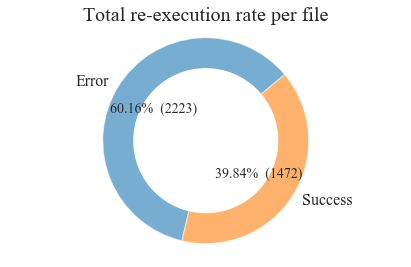

In [196]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

def get_success_rates(df):
    print "Total number of entries: "+ str(len(df))
    print "Total number after bad DOIs are removed: "+ str(len(df))
    
    print "Unique DOIs: "+ str(len(df['doi'].unique()))
    
    # calculate success
    success = (df['result'] == 'success').sum()
    print "Success: " + str(success)+ " out of " + str(len(df)) +" => "+ str(success*1.0/len(df))
    
    til = (df['result'] == 'time limit exceeded').sum()
    print "TIL: " + str(til)+ " out of " + str(len(df)) +" => "+ str(til*1.0/len(df))
    
    error = len(df)-til-success
    print "Error: " + str(error)+ " out of " + str(len(df)) +" => "+ str(error*1.0/len(df))
    
    return [error, success]

def plot_code(df, plot_title, plot_name, aggregation=False):
    labels = ['Error', 'Success']
    if aggregation:
        sizes = get_aggregated(df)
    else:
        sizes = get_success_rates(df)
     
    fig1, ax1 = plt.subplots()
    plt.rcParams['font.size'] = 16
    ax1.pie(sizes, labels=labels, autopct=make_autopct(sizes), startangle=40,  \
            textprops={'fontsize': 14},wedgeprops={'alpha':0.6})

    #draw circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')

    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')  
    plt.title(plot_title, size=20)
    plt.tight_layout()

    plt.show()
    fig1.savefig("plots/{}".format(plot_name), dpi=100)
    
dfe = df[df.result.notnull()]
plot_code(dfe, "Total re-execution rate per file", "aggregated_env.png")

# Same for `no env` data

In [35]:
df_32_env = pd.read_csv("data/one-hour-run-data/run_log_r32_no_env.csv", sep="\t", names=["doi", "file", "r32"])
df_36_env = pd.read_csv("data/one-hour-run-data/run_log_r36_no_env.csv", sep="\t", names=["doi", "file", "r36"])
df_40_env = pd.read_csv("data/one-hour-run-data/run_log_r40_no_env.csv", sep="\t", names=["doi", "file", "r40"])

In [36]:
len(df_32_env)

7088

In [37]:
print(len(df_36_env))

4042


In [38]:
print(len(df_40_env))

7149


## Merge results in one df

In [39]:
df = pd.merge(df_32_env,df_36_env,on=['doi','file'], how='outer')

In [40]:
len(df)

7310

In [41]:
df = pd.merge(df,df_40_env,on=['doi','file'], how='outer')

In [42]:
len(df)

7985

## Combine results

In [43]:
df['result'] = df.apply(get_combined_result, axis=1)
df['success'] = df['result'].apply(get_success)

In [44]:
df.head(10)

,doi,file,r32,r36,r40,result,success
0,doi:10.7910/DVN/XFQZI2,Condemnation.R,Error in library(readstata13) : there is no pa...,NaN,NaN,NaN,NaN
1,doi:10.7910/DVN/WGPDBS,Replication_of_Figures.R,success,success,success,success,1.0
2,doi:10.7910/DVN/BPON3K,fig_10_effect_of_winning_on_gov.R,Error in library(gridExtra) : there is no pack...,NaN,Error in library(gridExtra) : there is no pack...,NaN,NaN
3,doi:10.7910/DVN/BPON3K,fig_11_rd_placebo.R,Error in library(gridExtra) : there is no pack...,NaN,Error in library(gridExtra) : there is no pack...,NaN,NaN
4,doi:10.7910/DVN/BPON3K,fig_12_historical_trend.R,Error in library(ggthemes) : there is no packa...,NaN,Error in library(ggthemes) : there is no packa...,NaN,NaN
5,doi:10.7910/DVN/BPON3K,fig_13_plot_loyalty_df_pct.R,Error in library(gridExtra) : there is no pack...,NaN,Error in library(gridExtra) : there is no pack...,NaN,NaN
6,doi:10.7910/DVN/BPON3K,fig_14_effect_on_individual_parties.R,Error in library(gridExtra) : there is no pack...,NaN,Error in library(gridExtra) : there is no pack...,NaN,NaN
7,doi:10.7910/DVN/BPON3K,fig_2_fig_4_party_switching.R,Error in library(gridExtra) : there is no pack...,NaN,Error in library(gridExtra) : there is no pack...,NaN,NaN
8,doi:10.7910/DVN/BPON3K,fig_3_effect_of_winning_on_federal_congress.R,Error in library(gridExtra) : there is no pack...,NaN,Error in library(gridExtra) : there is no pack...,NaN,NaN
9,doi:10.7910/DVN/BPON3K,fig_5_tab_7_rd_robust_estimations.R,Error in library(gridExtra) : there is no pack...,NaN,Error in library(gridExtra) : there is no pack...,NaN,NaN


In [45]:
len(df)

7985

# Exclude bad DOIs

In [46]:
er_362 = pd.read_csv("data/one-hour-run-data/run_log_r36_no_env_download.csv", sep="\t", names=["doi", "fileid", "status"])
er_322 = pd.read_csv("data/one-hour-run-data/run_log_r32_no_env_download.csv", sep="\t", names=["doi", "fileid", "status"])
er_402 = pd.read_csv("data/one-hour-run-data/run_log_r40_no_env_download.csv", sep="\t", names=["doi", "fileid", "status"])

error_data = [er_322, er_362, er_402]

exclude = []
for er in error_data:
    temp = er[er.status != 'ok']
    bad_dois = temp['doi'].unique().tolist()
    exclude.append(set(bad_dois))
    
bad_dois = exclude[0] & exclude[1] & exclude[2] 
bad_dois = list(bad_dois)

In [47]:
df = df.drop(df[df.doi.isin(bad_dois) & (df['result'] != 'success')].index)

In [48]:
df.tail()

,doi,file,r32,r36,r40,result,success
7980,doi:10.7910/DVN/NFXS5Z,psrm_supplementary_scriptX.R,NaN,NaN,Error in library(stargazer) : there is no pack...,NaN,NaN
7981,doi:10.7910/DVN/UMG39H,Figures.R,NaN,NaN,"Error: unexpected symbol in \load(directory of\""""",NaN,NaN
7982,doi:10.7910/DVN/UMG39H,Table1.R,NaN,NaN,Error in read.dta('directory') : unable to o...,NaN,NaN
7983,doi:10.7910/DVN/UMG39H,Table2.R,NaN,NaN,"Error in readChar(con, 5L, useBytes = TRUE) : ...",NaN,NaN
7984,doi:10.7910/DVN/T9WESH,unknown,NaN,NaN,download error,NaN,NaN


In [49]:
len(df)

7659

In [50]:
len(df.doi.unique())

2071

## Save results

In [212]:
df2 = df

In [213]:
df.to_csv('aggregate_results_no_env.csv')

# Quick check

Total number of entries: 3830
Total number after bad DOIs are removed: 3830
Unique DOIs: 1388
Success: 952 out of 3830 => 0.2485639686684073
TIL: 0 out of 3830 => 0.0
Error: 2878 out of 3830 => 0.7514360313315926


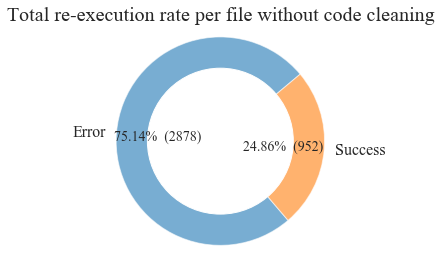

In [214]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

def get_success_rates(df):
    print "Total number of entries: "+ str(len(df))
    print "Total number after bad DOIs are removed: "+ str(len(df))
    
    print "Unique DOIs: "+ str(len(df['doi'].unique()))
    
    # calculate success
    success = (df['result'] == 'success').sum()
    print "Success: " + str(success)+ " out of " + str(len(df)) +" => "+ str(success*1.0/len(df))
    
    til = (df['result'] == 'time limit exceeded').sum()
    print "TIL: " + str(til)+ " out of " + str(len(df)) +" => "+ str(til*1.0/len(df))
    
    error = len(df)-til-success
    print "Error: " + str(error)+ " out of " + str(len(df)) +" => "+ str(error*1.0/len(df))
    
    return [error, success]

def plot_code(df, plot_title, plot_name, aggregation=False):
    labels = ['Error', 'Success']
    if aggregation:
        sizes = get_aggregated(df)
    else:
        sizes = get_success_rates(df)
     
    fig1, ax1 = plt.subplots()
    plt.rcParams['font.size'] = 16
    ax1.pie(sizes, labels=labels, autopct=make_autopct(sizes), startangle=40,  \
            textprops={'fontsize': 14},wedgeprops={'alpha':0.6})

    #draw circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')

    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')  
    plt.title(plot_title, size=20)
    plt.tight_layout()

    plt.show()
    fig1.savefig("plots/{}".format(plot_name), dpi=100)
    
dfe = df[df.result.notnull()]
plot_code(dfe, "Total re-execution rate per file without code cleaning", "aggregated_no_env.png")

# Validation test

In [215]:
df = pd.merge(df1,df2,on=['doi','file'], how='outer')

In [216]:
df.head()

,doi,file,r32_x,r36_x,r40_x,result_x,success_x,r32_y,r36_y,r40_y,result_y,success_y
0,doi:10.7910/DVN/XFQZI2,Condemnation.R,"Error in eval(expr, envir, enclos) : could not...",Error in read.dta13('Condemnation.dta') : co...,NaN,NaN,NaN,Error in library(readstata13) : there is no pa...,NaN,NaN,NaN,NaN
1,doi:10.7910/DVN/WGPDBS,Replication_of_Figures.R,success,success,success,success,1.0,success,success,success,success,1.0
2,doi:10.7910/DVN/BPON3K,fig_10_effect_of_winning_on_gov.R,"Error in diag(vcovHC(DMareg, type = 'HC3')) : ...","Error in vcovHC(DMareg, type = 'HC3') : could ...","Error in vcovHC(DMareg, type = 'HC3') : could ...","Error in vcovHC(DMareg, type = 'HC3') : could ...",0.0,Error in library(gridExtra) : there is no pack...,NaN,Error in library(gridExtra) : there is no pack...,NaN,NaN
3,doi:10.7910/DVN/BPON3K,fig_11_rd_placebo.R,"Error in ggsave('placebo.pdf', plot = placebo,...",success,success,success,1.0,Error in library(gridExtra) : there is no pack...,NaN,Error in library(gridExtra) : there is no pack...,NaN,NaN
4,doi:10.7910/DVN/BPON3K,fig_12_historical_trend.R,"Error in ggsave('historical_trend.pdf', plot =...",success,success,success,1.0,Error in library(ggthemes) : there is no packa...,NaN,Error in library(ggthemes) : there is no packa...,NaN,NaN


In [220]:
print(len(df[(df['success_x'] == 1) & (df['success_y'] == 1)]))

843


In [223]:
len(df[(df['success_y'].isnull())])

4779

In [221]:
len(df)

8609

# Aggregated per dataset

In [64]:
df = pd.read_csv("aggregate_results_env.csv", index_col=0)

In [65]:
df.head()

,doi,file,r32,r36,r40,result
0,doi:10.7910/DVN/XFQZI2,Condemnation.R,"Error in eval(expr, envir, enclos) : could not...",Error in read.dta13('Condemnation.dta') : co...,NaN,NaN
1,doi:10.7910/DVN/WGPDBS,Replication_of_Figures.R,success,success,success,success
2,doi:10.7910/DVN/BPON3K,fig_10_effect_of_winning_on_gov.R,"Error in diag(vcovHC(DMareg, type = 'HC3')) : ...","Error in vcovHC(DMareg, type = 'HC3') : could ...","Error in vcovHC(DMareg, type = 'HC3') : could ...","Error in vcovHC(DMareg, type = 'HC3') : could ..."
3,doi:10.7910/DVN/BPON3K,fig_11_rd_placebo.R,"Error in ggsave('placebo.pdf', plot = placebo,...",success,success,success
4,doi:10.7910/DVN/BPON3K,fig_12_historical_trend.R,"Error in ggsave('historical_trend.pdf', plot =...",success,success,success


In [73]:
def plot_code(sizes, plot_title, plot_name):
    labels = ['Error', 'Success']
   
    fig1, ax1 = plt.subplots()
    plt.rcParams['font.size'] = 16
    ax1.pie(sizes, labels=labels, autopct=make_autopct(sizes), startangle=40,  \
            textprops={'fontsize': 14},wedgeprops={'alpha':0.6})

    #draw circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')

    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')  
    plt.title(plot_title, size=20)
    plt.tight_layout()

    plt.show()
    fig1.savefig("plots/{}".format(plot_name), dpi=100)

In [69]:
df2 = df.loc[~df['result'].isnull()].copy()
len(df2)

3695

In [70]:
df2.head()

,doi,file,r32,r36,r40,result
1,doi:10.7910/DVN/WGPDBS,Replication_of_Figures.R,success,success,success,success
2,doi:10.7910/DVN/BPON3K,fig_10_effect_of_winning_on_gov.R,"Error in diag(vcovHC(DMareg, type = 'HC3')) : ...","Error in vcovHC(DMareg, type = 'HC3') : could ...","Error in vcovHC(DMareg, type = 'HC3') : could ...","Error in vcovHC(DMareg, type = 'HC3') : could ..."
3,doi:10.7910/DVN/BPON3K,fig_11_rd_placebo.R,"Error in ggsave('placebo.pdf', plot = placebo,...",success,success,success
4,doi:10.7910/DVN/BPON3K,fig_12_historical_trend.R,"Error in ggsave('historical_trend.pdf', plot =...",success,success,success
5,doi:10.7910/DVN/BPON3K,fig_13_plot_loyalty_df_pct.R,Error in data.table(x) : object 'x' not found,Error in data.table(x) : object 'x' not found,Error in data.table(x) : object 'x' not found,Error in data.table(x) : object 'x' not found


In [71]:
ag_tot = set(df2['doi'].unique().tolist())
len(ag_tot)

1447

In [72]:
ag_suc = set(df2[df2.result == 'success']['doi'].unique().tolist())
len(ag_suc)

648

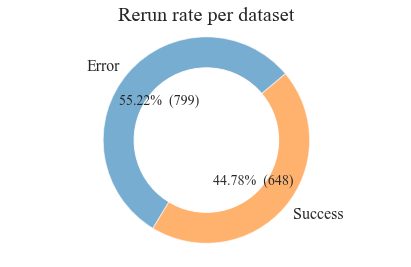

In [74]:
sizes = [len(ag_tot)-len(ag_suc), len(ag_suc)]
plot_code(sizes, "Rerun rate per dataset", "dataset_rate.png")